<a href="https://colab.research.google.com/github/Rahulx911/grid-6.0/blob/main/Freshness_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

# Disable mixed precision to avoid potential issues
mixed_precision.set_global_policy('float32')

# Limit GPU memory growth to prevent memory allocation issues
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# List of produce types (fruits and vegetables)
produce_types = [
    'Apple', 'Banana', 'Mango', 'Strawberry',  # Fruits
    'Bellpepper', 'Carrot', 'Cucumber', 'Potato', 'Tomato'  # Vegetables
]
num_classes = len(produce_types)  # We have 9 produce types in total

# Paths to the dataset
dataset_dir = '/content/drive/MyDrive/Fruits_Vegetables_Dataset(12000)'

# ImageDataGenerator without augmentations
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.2  # Split dataset into training and validation
)

# Function to create ResNet-50 model for multi-output (produce type + freshness)
def create_model(input_shape=(160, 160, 3), num_classes=9):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Dropout for regularization

    # Output 1: Produce Type Classification (9 classes: Apple, Banana, etc.)
    produce_type_output = Dense(num_classes, activation='softmax', name='produce_type_output',
                                kernel_regularizer=l2(0.001))(x)

    # Output 2: Freshness Classification (binary: fresh or rotten)
    freshness_output = Dense(1, activation='sigmoid', name='freshness_output',
                             kernel_regularizer=l2(0.001))(x)

    # Create the model with two outputs
    model = Model(inputs=base_model.input, outputs=[produce_type_output, freshness_output])

    # Compile the model with two losses (one for each output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss={
            'produce_type_output': 'categorical_crossentropy',  # Multi-class classification for produce type
            'freshness_output': 'binary_crossentropy'  # Binary classification for freshness
        },
        metrics={
            'produce_type_output': 'accuracy',
            'freshness_output': 'accuracy'
        }
    )

    return model

# Custom data generator to yield both produce type and freshness labels
def multi_output_data_generator(generator):
    while True:
        images = next(generator)
        batch_size = images.shape[0]
        produce_labels = np.zeros((batch_size, num_classes))  # One-hot encoding for produce types
        freshness_labels = np.zeros((batch_size, 1))  # Binary encoding for freshness (fresh=1, rotten=0)

        for i, filename in enumerate(generator.filenames[generator.batch_index - batch_size:generator.batch_index]):
            # Get the directory name (FreshApple, RottenApple, etc.)
            dir_name = os.path.split(os.path.dirname(filename))[-1]

            # Determine the freshness (fresh or rotten)
            freshness = 1 if 'Fresh' in dir_name else 0

            # Determine the produce type based on directory name
            produce_type = [p for p in produce_types if p.lower() in dir_name.lower()]
            if produce_type:
                produce_type_index = produce_types.index(produce_type[0])
                produce_labels[i, produce_type_index] = 1  # One-hot encoding for produce type
                freshness_labels[i] = freshness

        yield images, {'produce_type_output': produce_labels, 'freshness_output': freshness_labels}

# Training for all produce types (fruits and vegetables)
def train_model():
    # Load data with reduced batch size
    train_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(160, 160),
        batch_size=32,  # Reduced batch size to prevent memory issues
        class_mode=None,
        subset='training',
        shuffle=True
    )

    validation_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(160, 160),
        batch_size=32,  # Reduced batch size
        class_mode=None,
        subset='validation',
        shuffle=True
    )

    # Create the multi-output model
    model = create_model()

    # Callbacks for learning rate reduction and model checkpointing
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
    model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model.keras', save_best_only=True, monitor='val_loss', verbose=1)

    # Train the model
    history = model.fit(
        multi_output_data_generator(train_generator),
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=multi_output_data_generator(validation_generator),
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=100,  # Reduced number of epochs to start with
        callbacks=[reduce_lr, model_checkpoint]
    )

    # Save the final model
    model.save('/content/drive/MyDrive/final_unified_model.keras')
    print("Training completed!")

# Run the training function
train_model()


Physical devices cannot be modified after being initialized
Found 9590 images belonging to 2 classes.
Found 2396 images belonging to 2 classes.
Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - freshness_output_accuracy: 0.5023 - loss: 3.2771 - produce_type_output_accuracy: 0.1122 
Epoch 1: val_loss improved from inf to 2.01395, saving model to /content/drive/MyDrive/best_model.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 7185s 24s/step - freshness_output_accuracy: 0.5023 - loss: 3.2795 - produce_type_output_accuracy: 0.1123 - val_freshness_output_accuracy: 0.4295 - val_loss: 2.0139 - val_produce_type_output_accuracy: 0.2762 - learning_rate: 1.0000e-05
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - freshness_output_accuracy: 0.5070 - loss: 3.0366 - produce_type_output_accuracy: 0.1217
Epoch 2: val_loss did not improve from 2.01395
299/299 ━━━━━━━━━━━━━━━━━━━━ 97s 234ms/step - freshness_output_accuracy: 0.5070 - loss: 3.0389 - produce_type_output_accuracy: 0.1217 - val_freshness_ou

In [80]:
!pip install tensorflow-datasets

import tensorflow as tf
import tensorflow_datasets as tfds

In [81]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import drive

# Mount Google Drive to save and load models
drive.mount('/content/drive')

# List of fruits and vegetables for classification
fruits = ['Apple', 'Banana', 'Mango', 'Strawberry']
vegetables = ['Bellpepper', 'Carrot', 'Cucumber', 'Potato', 'Tomato']
produce_types = fruits + vegetables

# Load the existing unified model from Google Drive
existing_model_path = '/content/drive/MyDrive/final_unified_model.keras'
existing_model = load_model(existing_model_path)

# Function to fine-tune the existing model
def fine_tune_model(existing_model, learning_rate=1e-4, dropout_rate=0.5):
    model = tf.keras.models.clone_model(existing_model)
    for layer in model.layers:
        layer.trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss={'produce_type_output': 'categorical_crossentropy', 'freshness_output': 'binary_crossentropy'},
        metrics={'produce_type_output': 'accuracy', 'freshness_output': 'accuracy'}
    )
    return model

# Function to create MobileNet model
def create_mobilenet_model(input_shape=(160, 160, 3), num_classes=9):
    base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    produce_type_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='produce_type_output')(x)
    freshness_output = tf.keras.layers.Dense(1, activation='sigmoid', name='freshness_output')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=[produce_type_output, freshness_output])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss={'produce_type_output': 'categorical_crossentropy', 'freshness_output': 'binary_crossentropy'},
        metrics={'produce_type_output': 'accuracy', 'freshness_output': 'accuracy'}
    )
    return model

# Function to create EfficientNet model
def create_efficientnet_model(input_shape=(160, 160, 3), num_classes=9):
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    produce_type_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='produce_type_output')(x)
    freshness_output = tf.keras.layers.Dense(1, activation='sigmoid', name='freshness_output')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=[produce_type_output, freshness_output])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss={'produce_type_output': 'categorical_crossentropy', 'freshness_output': 'binary_crossentropy'},
        metrics={'produce_type_output': 'accuracy', 'freshness_output': 'accuracy'}
    )
    return model

# Create two additional models
model2 = fine_tune_model(existing_model)
model3 = create_mobilenet_model()
model4 = create_efficientnet_model()

# Save the models to Google Drive
model2.save('/content/drive/MyDrive/model2_fine_tuned.keras')
model3.save('/content/drive/MyDrive/model3_mobilenet.keras')
model4.save('/content/drive/MyDrive/model4_efficientnet.keras')

print("Models saved successfully to Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Models saved successfully to Google Drive.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Category: Fruit
Predicted Produce Type: Banana
Freshness Index: 0.31
The produce is: Not Fresh
Estimated shelf life: 1-3 days


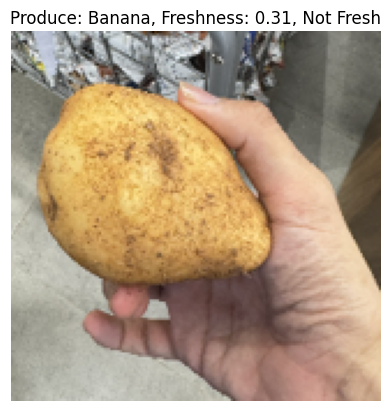

In [44]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

# List of fruits and vegetables for classification
fruits = ['Apple', 'Banana', 'Mango', 'Strawberry']
vegetables = ['Bellpepper', 'Carrot', 'Cucumber', 'Potato', 'Tomato']

produce_types = fruits + vegetables  # Combine fruits and vegetables

# Load the trained models
existing_model = tf.keras.models.load_model('/content/drive/MyDrive/final_unified_model.keras')
model1 = tf.keras.models.load_model('/content/drive/MyDrive/model2_fine_tuned.keras')
model2 = tf.keras.models.load_model('/content/drive/MyDrive/model3_mobilenet.keras')
model3 = tf.keras.models.load_model('/content/drive/MyDrive/model4_efficientnet.keras')

# Assign weights based on validation performance for each class
weights_per_class = {
    'Apple': [0.4, 0.2, 0.2, 0.1],
    'Carrot': [0.3, 0.4, 0.2, 0.1],
     'Cucumber': [0.3, 0.2, 0.2, 0.1]
    # Add weights for other classes as needed
}

# Function to preprocess the user-provided image for the model
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    image = image.resize((160, 160))  # Resize to match model input
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to make predictions using an ensemble of models with class-specific weighted averaging
def ensemble_prediction(image_path):
    # Preprocess the input image
    image = preprocess_image(image_path)

    # Make predictions using each model
    produce_pred_existing, freshness_pred_existing = existing_model.predict(image)
    produce_pred1, freshness_pred1 = model1.predict(image)
    produce_pred2, freshness_pred2 = model2.predict(image)
    produce_pred3, freshness_pred3 = model3.predict(image)

    # Get the predicted produce type from existing model
    produce_type_index_existing = np.argmax(produce_pred_existing[0])
    produce_type = produce_types[produce_type_index_existing]

    # Retrieve class-specific weights
    weights = weights_per_class.get(produce_type, [0.25, 0.25, 0.25, 0.25])  # Default weights if not found

    # Weighted average of the predictions
    average_produce_pred = (
        weights[0] * produce_pred_existing[0] +
        weights[1] * produce_pred1[0] +
        weights[2] * produce_pred2[0] +
        weights[3] * produce_pred3[0]
    )
    average_freshness_pred = (
        weights[0] * freshness_pred_existing[0][0] +
        weights[1] * freshness_pred1[0][0] +
        weights[2] * freshness_pred2[0][0] +
        weights[3] * freshness_pred3[0][0]
    )

    # Get the final predicted produce type
    produce_type_index = np.argmax(average_produce_pred)
    final_produce_type = produce_types[produce_type_index]

    # Determine if it's a fruit or vegetable
    category = "Fruit" if final_produce_type in fruits else "Vegetable"

    # Determine freshness classification
    is_fresh = "Fresh" if average_freshness_pred > 0.5 else "Not Fresh"

    return category, final_produce_type, average_freshness_pred, is_fresh

# Function to estimate shelf life based on freshness index
def predict_shelf_life(freshness_index):
    if freshness_index > 0.8:
        return "Estimated shelf life: 7+ days"
    elif 0.5 < freshness_index <= 0.8:
        return "Estimated shelf life: 3-7 days"
    elif 0.3 < freshness_index <= 0.5:
        return "Estimated shelf life: 1-3 days"
    else:
        return "Estimated shelf life: Less than 1 day"

# Main function to check the user-provided image
def check_image(image_path):
    # Use the ensemble prediction method for produce type and freshness
    category, produce_type, freshness_index, is_fresh = ensemble_prediction(image_path)

    # Estimate shelf life
    shelf_life = predict_shelf_life(freshness_index)

    # Display the results
    print(f"Category: {category}")
    print(f"Predicted Produce Type: {produce_type}")
    print(f"Freshness Index: {freshness_index:.2f}")
    print(f"The produce is: {is_fresh}")
    print(shelf_life)

    # Optionally, display the image with the predicted result
    image = preprocess_image(image_path)[0]  # Remove batch dimension for visualization
    plt.imshow(image)
    plt.title(f"Produce: {produce_type}, Freshness: {freshness_index:.2f}, {is_fresh}")
    plt.axis('off')
    plt.show()

# Test with a user-provided image (provide the actual image path)
image_path = '/content/Screenshot 2024-10-19 at 6.58.11 AM.png'  # Update this with your actual image path
check_image(image_path)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 438 variables whereas the saved optimizer has 442 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 438 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 176 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 436 variables whereas the s

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Category: Vegetable
Predicted Produce Type: Unknown
Freshness Index: 0.41
The produce is: Fresh
Estimated shelf life: 1-3 days


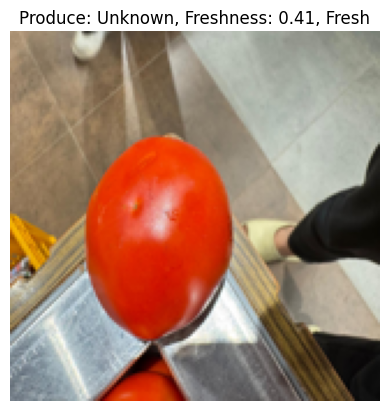

In [75]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler

# List of fruits and vegetables for classification
fruits = ['Apple', 'Banana', 'Mango', 'Strawberry']
vegetables = ['Bellpepper', 'Carrot', 'Cucumber', 'Potato', 'Tomato']
produce_types = fruits + vegetables

# Load the trained models
existing_model = tf.keras.models.load_model('/content/drive/MyDrive/final_unified_model.keras')
model1 = tf.keras.models.load_model('/content/drive/MyDrive/model2_fine_tuned.keras')
model2 = tf.keras.models.load_model('/content/drive/MyDrive/model3_mobilenet.keras')
model3 = tf.keras.models.load_model('/content/drive/MyDrive/model4_efficientnet.keras')

# Assign weights based on validation performance for each class
weights_per_class = {
    'Apple': [0.4, 0.3, 0.2, 0.1],
    'Carrot': [0.25, 0.35, 0.3, 0.1],
    'Cucumber': [0.3, 0.2, 0.3, 0.2],
    # Add weights for other classes as needed
}

# Function to extract color histograms
def extract_color_histogram(image, bins=32):
    hist_r = np.histogram(image[:, :, 0], bins=bins, range=(0, 256))[0]
    hist_g = np.histogram(image[:, :, 1], bins=bins, range=(0, 256))[0]
    hist_b = np.histogram(image[:, :, 2], bins=bins, range=(0, 256))[0]
    hist_r = hist_r / np.sum(hist_r)
    hist_g = hist_g / np.sum(hist_g)
    hist_b = hist_b / np.sum(hist_b)
    return np.concatenate([hist_r, hist_g, hist_b])

# Function to extract texture features using Local Binary Pattern (LBP)
def extract_texture_features(image, radius=1, n_points=8):
    gray_image = np.mean(image, axis=2).astype(np.uint8)
    lbp = local_binary_pattern(gray_image, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# Function to preprocess the user-provided image for the model
def preprocess_image(image_path):
    image = Image.open(image_path)
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    image = image.resize((160, 160))
    image_np = np.array(image) / 255.0
    return image_np

# Function to preprocess image and extract additional features
def preprocess_image_with_features(image_path):
    image_np = preprocess_image(image_path)

    # Extract color histograms and texture features
    color_features = extract_color_histogram((image_np * 255).astype(np.uint8))
    texture_features = extract_texture_features((image_np * 255).astype(np.uint8))

    # Combine and scale features
    scaler = StandardScaler()
    color_features = scaler.fit_transform(color_features.reshape(1, -1)).flatten()
    texture_features = scaler.fit_transform(texture_features.reshape(1, -1)).flatten()
    combined_features = np.concatenate([color_features, texture_features])

    image_np = np.expand_dims(image_np, axis=0)
    combined_features = np.expand_dims(combined_features, axis=0)

    return image_np, combined_features

# Function to make predictions using an ensemble of models with class-specific weighted averaging
def ensemble_prediction(image_path):
    # Preprocess the input image and extract additional features
    image, additional_features = preprocess_image_with_features(image_path)

    # Make predictions using each model
    produce_pred_existing, freshness_pred_existing = existing_model.predict(image)
    produce_pred1, freshness_pred1 = model1.predict(image)
    produce_pred2, freshness_pred2 = model2.predict(image)
    produce_pred3, freshness_pred3 = model3.predict(image)

    # Get the predicted produce type from existing model
    produce_type_index_existing = np.argmax(produce_pred_existing[0])
    produce_type = produce_types[produce_type_index_existing]

    # Retrieve class-specific weights
    weights = weights_per_class.get(produce_type, [0.25, 0.25, 0.25, 0.25])  # Default weights if not found

    # Weighted average of the predictions
    average_produce_pred = (
        weights[0] * produce_pred_existing[0] +
        weights[1] * produce_pred1[0] +
        weights[2] * produce_pred2[0] +
        weights[3] * produce_pred3[0]
    )
    average_freshness_pred = (
        weights[0] * freshness_pred_existing[0][0] +
        weights[1] * freshness_pred1[0][0] +
        weights[2] * freshness_pred2[0][0] +
        weights[3] * freshness_pred3[0][0]
    )

    # Get the final predicted produce type
    produce_type_index = np.argmax(average_produce_pred)
    final_produce_type = produce_types[produce_type_index]

    # Confidence check for the prediction
    confidence_threshold = 0.3
    max_confidence = np.max(average_produce_pred)
    if max_confidence < confidence_threshold:
        final_produce_type = "Unknown"  # Mark as unknown if confidence is too low

    # Determine if it's a fruit or vegetable
    category = "Fruit" if final_produce_type in fruits else "Vegetable"

    # Determine freshness classification
    is_fresh = "Fresh" if average_freshness_pred > 0.4 else "Not Fresh"

    return category, final_produce_type, average_freshness_pred, is_fresh

# Function to estimate shelf life based on freshness index
def predict_shelf_life(freshness_index):
    if freshness_index > 0.8:
        return "Estimated shelf life: 7+ days"
    elif 0.5 < freshness_index <= 0.8:
        return "Estimated shelf life: 3-7 days"
    elif 0.3 < freshness_index <= 0.5:
        return "Estimated shelf life: 1-3 days"
    else:
        return "Estimated shelf life: Less than 1 day"

# Main function to check the user-provided image
def check_image(image_path):
    # Use the ensemble prediction method for produce type and freshness
    category, produce_type, freshness_index, is_fresh = ensemble_prediction(image_path)

    # Estimate shelf life
    shelf_life = predict_shelf_life(freshness_index)

    # Display the results
    print(f"Category: {category}")
    print(f"Predicted Produce Type: {produce_type}")
    print(f"Freshness Index: {freshness_index:.2f}")
    print(f"The produce is: {is_fresh}")
    print(shelf_life)

    # Optionally, display the image with the predicted result
    image = preprocess_image(image_path)
    plt.imshow(image)
    plt.title(f"Produce: {produce_type}, Freshness: {freshness_index:.2f}, {is_fresh}")
    plt.axis('off')
    plt.show()

# Test with a user-provided image (provide the actual image path)
image_path = '/content/tomato_fresh_image.jpeg'
check_image(image_path)
